# Bidirectional RNN for Digit Classification
In this tutorial we will implement a simple Recurrent Neural Network in TensorFlow for classifying MNIST digits.

![RNN](files/files/01.svg)

*Fig1. Sample RNN structure and its unfolded representation*


## 1. Import the required libraries:
We will start with importing the required libraries to our Python environment.

In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn

/home/cougarnet.uh.edu/amobiny/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Load the MNIST data

For this tutorial we use the MNIST dataset. MNIST is a dataset of handwritten digits. If you are into machine learning, you might have heard of this dataset by now. MNIST is kind of benchmark of datasets for deep learning. One other reason that we use the MNIST is that it is easily accesible through Tensorflow.

The dataset contains 55,000 examples for training, 5,000 examples for validation and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST](files/files/02.png)


If you want to know more about the MNIST dataset you can check __Yann Lecun__'s [website](http://yann.lecun.com/exdb/mnist/).

### 1.1. Data dimension
Here, we specify the dimensions of the images which will be used in several places in the code below. Defining these variables makes it easier (compared with using hard-coded number all throughout the code) to modify them later. Ideally these would be inferred from the data that has been read, but here we just write the numbers.

To classify images using a recurrent neural network, we consider every image row as a sequence of pixels. Because MNIST image shape is 28x28 pixels, we will then handle 28 sequences of 28 timesteps for every sample.

In [2]:
# Data Dimension
num_input = 28          # MNIST data input (image shape: 28x28)
timesteps = 28          # Timesteps
n_classes = 10          # Number of classes, one class per digit

### 1.2. Helper functions to load the MNIST data

In this section, we'll write the function which automatically loads the MNIST data and returns it in our desired shape and format. If you wanna learn more about loading your data, you may read our __How to Load Data in TensorFlow __ tutorial which explains all the available methods to load your own data; no matter how big it is. Here, we'll simply write a function (load_data) which has two mode: train (which loads the training and validation images and their corresponding labels) and test (which loads the test images and their corresponding labels). 

In [3]:
def load_data(mode='train'):
    """
    Function to (download and) load the MNIST data
    :param mode: train or test
    :return: images and the corresponding labels
    """
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    if mode == 'train':
        x_train, y_train, x_valid, y_valid = mnist.train.images, mnist.train.labels, \
                                             mnist.validation.images, mnist.validation.labels
        return x_train, y_train, x_valid, y_valid
    elif mode == 'test':
        x_test, y_test = mnist.test.images, mnist.test.labels
    return x_test, y_test


def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y


def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

### 1.3. Load the data and display the sizes
Now we can use the defined helper function in "train" mode which loads the train and validation images and their corresponding labels. We'll also display their sizes:

In [4]:
x_train, y_train, x_valid, y_valid = load_data(mode='train')
print("Size of:")
print("- Training-set:\t\t{}".format(len(y_train)))
print("- Validation-set:\t{}".format(len(y_valid)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Validation-set:	5000


## 2. Hyperparameters

In [5]:
learning_rate = 0.001 # The optimization initial learning rate
epochs = 10           # Total number of training epochs
batch_size = 100      # Training batch size
display_freq = 100    # Frequency of displaying the training results

## 3. Network configuration

In [6]:
num_hidden_units = 128  # Number of hidden units of the RNN

## 4. Create network helper functions 
### 4.1. Helper functions for creating new variables

In [7]:
# weight and bais wrappers
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W',
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)


def bias_variable(shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b',
                           dtype=tf.float32,
                           initializer=initial)

### 4.2. Helper-function for creating a Bidirectional RNN

In [8]:
def BiRNN(x, weights, biases, timesteps, num_hidden):
    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, num_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, num_input)
    x = tf.unstack(x, timesteps, 1)

    # Define lstm cells with tensorflow
    # Forward direction cell
    lstm_fw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    # Backward direction cell
    lstm_bw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get BiRNN cell output
    outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                                 dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights) + biases

## 5. Create the network graph
### 5.1. Placeholders for the inputs (x) and corresponding labels (y)

In [9]:
# Placeholders for inputs (x) and outputs(y)
x = tf.placeholder(tf.float32, shape=[None, timesteps, num_input], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

### 5.2. Define the network

In [10]:
# create weight matrix initialized randomely from N~(0, 0.01)
W = weight_variable(shape=[2*num_hidden_units, n_classes])

# create bias vector initialized as zero
b = bias_variable(shape=[n_classes])

output_logits = BiRNN(x, W, b, timesteps, num_hidden_units)
y_pred = tf.nn.softmax(output_logits)

### 5.3. Define the loss function, optimizer, accuracy, and predicted class


In [11]:
# Model predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

# Define the loss function, optimizer, and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

### 5.4. Initialize all variables

In [12]:
# Creating the op for initializing all variables
init = tf.global_variables_initializer()

## 6. Train

In [13]:
sess = tf.InteractiveSession()
sess.run(init)
global_step = 0
# Number of training iterations in each epoch
num_tr_iter = int(len(y_train) / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    x_train, y_train = randomize(x_train, y_train)
    for iteration in range(num_tr_iter):
        global_step += 1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)
        x_batch = x_batch.reshape((batch_size, timesteps, num_input))
        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],
                                             feed_dict=feed_dict_batch)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch

    feed_dict_valid = {x: x_valid[:1000].reshape((-1, timesteps, num_input)), y: y_valid[:1000]}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Loss=2.30,	Training Accuracy=14.0%
iter 100:	 Loss=0.98,	Training Accuracy=66.0%
iter 200:	 Loss=0.63,	Training Accuracy=81.0%
iter 300:	 Loss=0.31,	Training Accuracy=91.0%
iter 400:	 Loss=0.31,	Training Accuracy=92.0%
iter 500:	 Loss=0.29,	Training Accuracy=95.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.22, validation accuracy: 93.5%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.15,	Training Accuracy=94.0%
iter 100:	 Loss=0.23,	Training Accuracy=92.0%
iter 200:	 Loss=0.14,	Training Accuracy=97.0%
iter 300:	 Loss=0.14,	Training Accuracy=96.0%
iter 400:	 Loss=0.21,	Training Accuracy=95.0%
iter 500:	 Loss=0.08,	Training Accuracy=99.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.13, validation accuracy: 96.7%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.07,	Training Accuracy=99

## 7. Test
### 7.1. Helper functions for plotting the results

In [14]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(np.squeeze(images[i]).reshape(28, 28), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)
    
def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

### 7.2. Run the test and plot some results

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
---------------------------------------------------------
Test loss: 0.07, test accuracy: 97.9%
---------------------------------------------------------


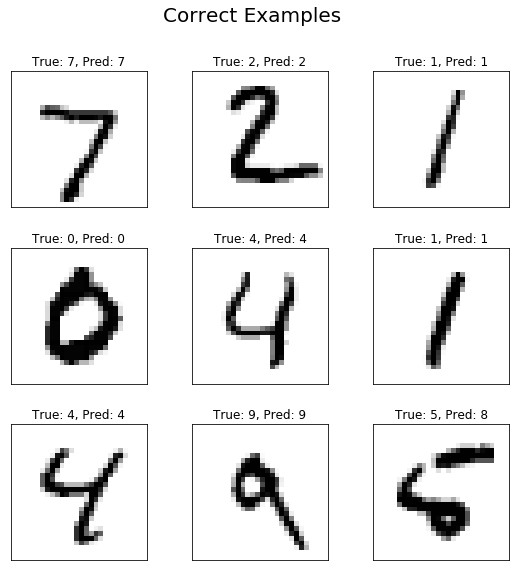

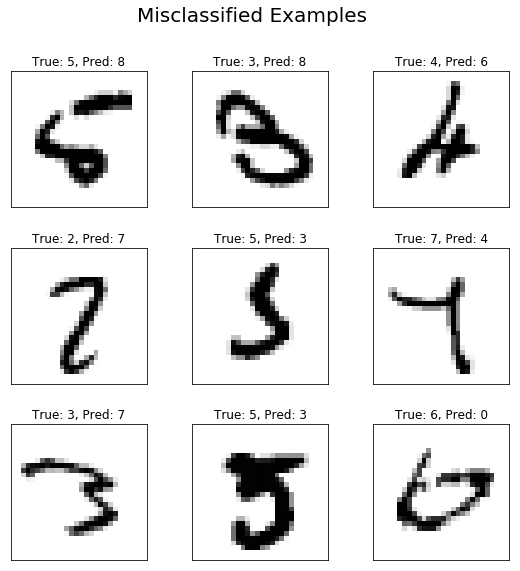

In [15]:
# Test the network (only on 1000 samples) after training
# Accuracy
x_test, y_test = load_data(mode='test')
feed_dict_test = {x: x_test[:1000].reshape((-1, timesteps, num_input)), y: y_test[:1000]}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')


# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test, axis=1)
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test[:1000], cls_true[:1000], cls_pred, title='Misclassified Examples')
plt.show()

After we are finished the testing, we will close the session to free the memory.

In [16]:
# close the session after you are done with testing
sess.close()

Thanks for reading! If you have any question or doubt, feel free to leave a comment in our [website](http://easy-tensorflow.com/).